# AlexNet网络的PyTorch实现

## 前期设置

#### 导入需要用到的包

In [1]:
import os
import tarfile
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

#### 设置运算设备

若有可用的GPU设备，则切换至GPU，否则使用CPU。

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### 设置超参数

In [3]:
num_classes = 10  # 分类任务的类别数
batch_size = 32  # 每个小批次包含的样本数量
epochs = 10  # 训练周期数
lr = 1e-3  # 学习率
weight_decay = 1e-5  # L2正则化惩罚系数

## 准备数据集

#### 导入数据集文件

若检测到未导入过数据集文件，则创建数据集存储路径，并将矩池云预置的数据集压缩文件解压至目标路径下。

In [4]:
if not os.path.exists('data/CIFAR-10'):
    os.mkdir('data/CIFAR-10')  # 创建数据存储路径
    with tarfile.open('/public/data/image/cifar10/cifar-10-batches-py.tar.gz') as tar:
        tar.extractall(path='data/CIFAR-10')  # 将数据集压缩文件解压至目标路径下

#### 图像预处理

先进行数据增广，再变形为AlexNet所需的输入形状（224 * 224），最后转换为tensor。

In [5]:
traintransform = transforms.Compose([
    transforms.Resize((224, 224)),  # 变形为AlexNet所需的输入形状（224 * 224）
    transforms.RandomHorizontalFlip(p=0.5),  # 以0.5的概率做水平翻转
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 在(-0.1, 0.1)的范围内随机调整亮度、对比度、饱和度、冷暖色调
    transforms.ToTensor(),  # 转换为tensor
])

testtransform = transforms.Compose([
    transforms.Resize((224, 224)),  # 变形为AlexNet所需的输入形状（224 * 224）
    transforms.ToTensor(),  # 转换为tensor
])

#### 创建训练集、测试集

导入训练集和测试集，并划分批次。对训练集进行打乱处理。

先使用torchvision.datasets中内置的CIFAR10类，将数据集文件转换为PyTorch中的数据集。然后使用DataLoader将数据集转化为分批次的数据读取器，可直接用于训练。

In [6]:
trainset = torchvision.datasets.CIFAR10(root='data/CIFAR-10', train=True, transform=traintransform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)  # 进行打乱

testset = torchvision.datasets.CIFAR10(root='data/CIFAR-10', train=False, transform=testtransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)  # 不进行打乱

#### 展示数据集样例

查看训练集第一个批次中的图片。

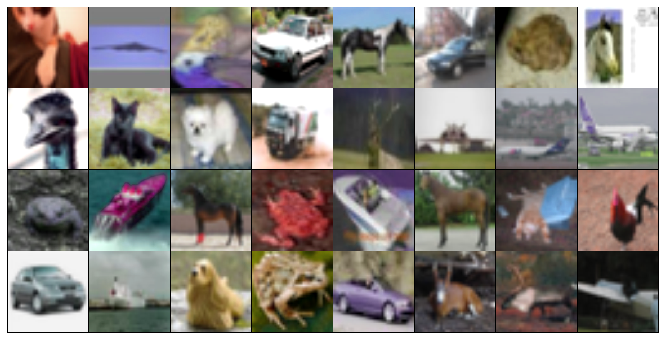

In [7]:
images = next(iter(trainloader))[0]  # 训练集第一个批次中的图片
plt.figure(figsize=(12, 6))
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

## 构建模型

将模型包装成一个类，继承PyTorch内置的nn.Module类。

forward方法是该类一个特殊的方法。在运行outputs = model(inputs)时，模型会自动调用forward方法。

In [8]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()  # 调用nn.Module类的构造函数
        
        # 特征提取模块
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),  # inplace=True意为在原tensor上操作，不产生新的tensor
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # 分类器模块
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
        
        self.to(device)  # 将模型中所有参数tensor切换到GPU存储模式
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)  # 拉直特征tensor
        x = self.classifier(x)
        return x

model = AlexNet()
model  # 展示模型的结构

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

## 训练模型

先定义几个训练中会用到的函数。

In [9]:
# 计算模型预测准确率
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

In [10]:
# 模型验证
def validate(model, testloader):
    val_loss = 0
    val_acc = 0
    
    model.eval()  # 模型切换到预测模式
    
    for batch in testloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    
    model.train()  # 模型切换到训练模式
    
    val_loss /= len(testloader)  # 计算平均损失
    val_acc /= len(testloader)  # 计算平均准确率
    
    return val_loss, val_acc

In [11]:
# 模型训练
def train(model, trainloader, testloader=None, optimizer=torch.optim.Adam, epochs=1, lr=1e-3, weight_decay=0):
    model.train()  # 模型切换到训练模式
    
    optim = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)  # 设置优化器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', patience=5)  # 设置学习率衰减

    history = []  # 存储训练历史
    
    for epoch in range(1, epochs + 1):
        
        result = {'train_loss': 0, 'train_acc': 0}  # 存储本epoch的训练结果
        
        start = time.time()  # 记录本epoch开始时间
        
        for batch in trainloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)  # 将tensor切换到GPU存储模式

            optim.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）

            outputs = model(inputs)  # 计算模型输出

            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            result['train_loss'] += loss.item()  # item方法提取出tensor中的数字

            acc = accuracy(outputs, labels)  # 计算准确率
            result['train_acc'] += acc

            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optim.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        
        end = time.time()  # 记录本epoch结束时间
        
        result['train_loss'] /= len(trainloader)  # 计算平均损失
        result['train_acc'] /= len(trainloader)  # 计算平均准确率
        
        if testloader:  # 若有测试集
            result['val_loss'], result['val_acc'] = validate(model, testloader)  # 计算测试集上的损失函数和准确率
            print(f"Epoch [{epoch}/{epochs}], time: {end - start:.2f}s, loss: {result['train_loss']:.4f}, acc: {result['train_acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")  # 打印训练结果
            scheduler.step(result['val_loss'])  # 若监测到连续5个epoch中val_loss未明显下降，则降低学习率
        else:
            print(f"Epoch [{epoch}/{epochs}], time: {end - start:.2f}s, loss: {result['train_loss']:.4f}, acc: {result['train_acc']:.4f}")  # 打印训练结果
        
        history.append(result)  # 将本epoch的训练结果存入训练历史
    
    return history

使用train函数训练模型。每个epoch的各项训练结果会自动打印。

In [12]:
history = train(model, trainloader, testloader, epochs=epochs, lr=lr, weight_decay=weight_decay)

Epoch [1/10], time: 386.28s, loss: 1.9148, acc: 0.2860, val_loss: 1.6486, val_acc: 0.3941
Epoch [2/10], time: 384.58s, loss: 1.6180, acc: 0.4079, val_loss: 1.5494, val_acc: 0.4260
Epoch [3/10], time: 385.42s, loss: 1.5097, acc: 0.4521, val_loss: 1.5102, val_acc: 0.4443
Epoch [4/10], time: 385.61s, loss: 1.4329, acc: 0.4819, val_loss: 1.3774, val_acc: 0.4988
Epoch [5/10], time: 385.75s, loss: 1.3688, acc: 0.5051, val_loss: 1.3384, val_acc: 0.5175
Epoch [6/10], time: 385.54s, loss: 1.3236, acc: 0.5290, val_loss: 1.3158, val_acc: 0.5295
Epoch [7/10], time: 385.37s, loss: 1.2841, acc: 0.5405, val_loss: 1.3660, val_acc: 0.5258
Epoch [8/10], time: 385.70s, loss: 1.2541, acc: 0.5557, val_loss: 1.2534, val_acc: 0.5565
Epoch [9/10], time: 385.84s, loss: 1.2277, acc: 0.5635, val_loss: 1.2542, val_acc: 0.5567
Epoch [10/10], time: 386.01s, loss: 1.2057, acc: 0.5729, val_loss: 1.1948, val_acc: 0.5765


绘图展示训练过程中损失函数和准确率的变化情况。

In [13]:
def visualize_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # 创建画布与坐标轴
    
    # 绘制损失函数图
    ax1.plot(range(1, epochs + 1), [result['train_loss'] for result in history], color='b', label="Training loss")
    ax1.plot(range(1, epochs + 1), [result['val_loss'] for result in history], color='r', label="Validation loss")
    ax1.set_xticks(range(1, epochs + 1))  # 设置x轴的刻度
    ax1.legend(*ax1.get_legend_handles_labels(), loc='best', shadow=True)  # 添加图例

    # 绘制准确率图
    ax2.plot(range(1, epochs + 1), [result['train_acc'] for result in history], color='b', label="Training accuracy")
    ax2.plot(range(1, epochs + 1), [result['val_acc'] for result in history], color='r',label="Validation accuracy")
    ax2.set_xticks(range(1, epochs + 1))  # 设置x轴的刻度
    ax2.set_ylim([0, 1])  # 设置y轴的范围为(0, 1)
    ax2.legend(*ax2.get_legend_handles_labels(), loc='best', shadow=True)  # 添加图例

    plt.tight_layout()
    plt.show()

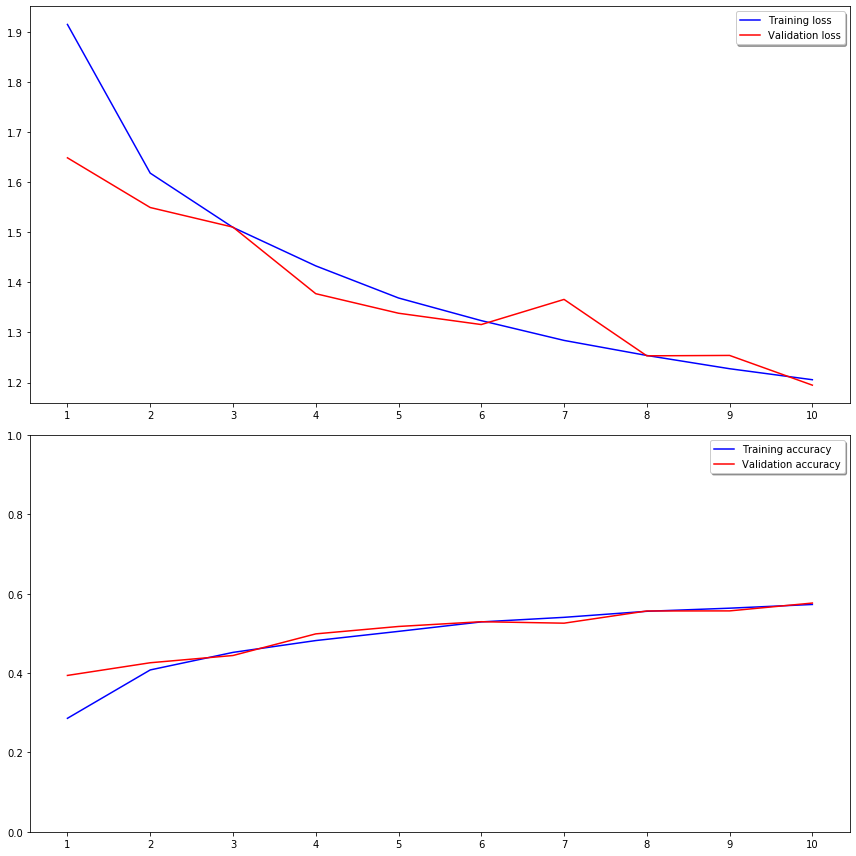

In [14]:
visualize_history(history)

最后，存储模型，以便之后不必重复训练，直接使用。

In [15]:
if not os.path.exists('models'):
    os.mkdir('models')
torch.save(model.state_dict(), 'models/alexnet.pth')

从模型文件中读取模型的例子如下。

In [16]:
new_model = AlexNet()
new_model.to(device)
new_model.load_state_dict(torch.load('models/alexnet.pth'))

<All keys matched successfully>

## 模型测试

从训练集中选取几张图片，使用模型做出预测，观察结果。

In [17]:
def predict(model, inputs):
    model.eval()  # 模型切换到预测模式
    outputs = model(inputs.to(device))
    preds = torch.max(outputs, dim=1)[1]
    return preds

In [18]:
testiter = iter(testloader)

多次运行以下代码块，即可测试不同的图片。

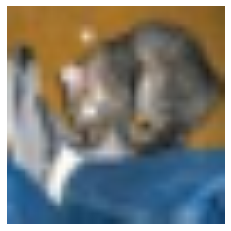

Prediction: cat


In [19]:
image = next(testiter)[0][0]
plt.axis('off')
plt.imshow(image.permute((1, 2, 0)))
plt.show()

pred = predict(model, image.unsqueeze(dim=0))
print('Prediction:', testset.classes[pred])